# Face Recognition

### NOTE: Do not install opencv-python pacakge. Try to install opencv-contrib-python package.

In [1]:
!pip install opencv-contrib-python

In [2]:
# import the required libraries
import cv2
import numpy as np
from PIL import Image
import os

# Detection and collecting samples

In [23]:
# loads the calssifier which will help us for the face detection
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

# used to open video file and video capturing device
video = cv2.VideoCapture(0)
video.set(3, 640)  # set Width
video.set(4, 480)  # set Height

# IP address for the video stream through smartphone
#address = "https://192.168.0.100:8080/video"
#video.open(address)

# For each person, Enter the user id => 1,2,3
face_id = input('\nEnter the user id: ')
print("\nInitializing camera.")

# Initialize individual sampling face count
count = 0

# initating an infinite loop that will capture video and will be later used to break the loop
while True:
    # ret is a boolean regarding whether or not there was a return at all, at the frame is each frame that is returned.
    ret, frame = video.read()

    # Convert image into grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # classifier function used to detect the faces, passing it some very important parameters, as scale factor, number of neighbors and minimum size of the detected face.
    faces = face_detector.detectMultiScale(gray, 1.3, 5)

    # making rectangle over the detected face
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        count += 1

        # before running the code make a folder name dataset in the same place as the code
        # Save the captured image into the dataset folder
        cv2.imwrite("dataset/User." + str(face_id) + '.' + str(count) + ".jpg", gray[y:y + h, x:x + w])
        cv2.imshow('image', frame)

    # Wait for a key press to exit
    k = cv2.waitKey(30) & 0xff
    if k == 27:  # press 'ESC' to quit
        break
    elif count >= 50:  # Take 50 face sample and stop video
        break

print("\nSamples collected.")
# Close all windows
video.release()
cv2.destroyAllWindows()


Enter the user id: 1

Initializing camera.

Samples collected.


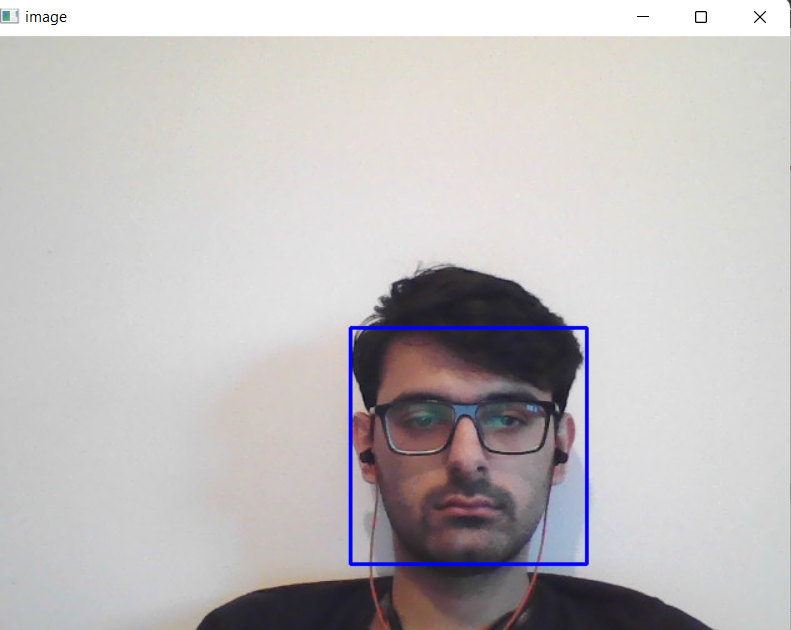

# Training

In [24]:
# Path for sample images
path = 'dataset'

# Local Binary Pattern Histogram for training the model
recognizer = cv2.face.LBPHFaceRecognizer_create()
# face detection classifier
detector = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml");


# function to get the images and label data
def getImagesAndLabels(p):
    # accesssing all files from dataset directory
    image_Paths = [os.path.join(p, f) for f in os.listdir(p)]
    # empty list to store array of face samples
    face_Samples = []
    # list to store the id of the samples
    id_ = []

    for image_Path in image_Paths:
        # open and identifies given image from the image path convert it into grayscale
        PIL_img = Image.open(image_Path).convert('L')
        # converting the image into numpy array
        img_numpy = np.array(PIL_img, 'uint8')
        # getting the user id from the image name by splitting the image name and taking the integer part of user id
        id = int(os.path.split(image_Path)[-1].split(".")[1])
        # detecting the face
        faces = detector.detectMultiScale(img_numpy)
        # using for loop to print rectangle for the numpy array image and append face and id into the empty list
        for (x, y, w, h) in faces:
            face_Samples.append(img_numpy[y:y + h, x:x + w])
            id_.append(id)
    return face_Samples, id_


print("\nTraining faces. Please Wait.")
faces, id_ = getImagesAndLabels(path)
# array input id_ and face_samples will be used to train the recognizer
recognizer.train(faces, np.array(id_))
# before running the program create a trainer folder to save the trained data
# Save the model into trainer/trainer.yml
recognizer.write('trainer/trainer.yml')
# Print that the model is trained and end program
print("\nTrained. Exiting Program.".format(len(np.unique(id_))))



Training faces. Please Wait.

Trained. Exiting Program.


# Recognition

In [25]:
# Local Binary Pattern Histogram for recognition
recognizer = cv2.face.LBPHFaceRecognizer_create()
# recognizer will use the training data to recognize the face
recognizer.read('trainer/trainer.yml')
# face detection classifier
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
font = cv2.FONT_HERSHEY_SIMPLEX
# initiate id counter
id = 0
# names related to ids: example ==> Hitesh: id=1,  etc
names = ['None', 'Hitesh', 'Miraya','Harsh']

# Initialize and start realtime video capture
video = cv2.VideoCapture(0)
video.set(3, 640)  # set video widht
video.set(4, 480)  # set video height

# Define min window size to be recognized as a face
minW = 0.1 * video.get(3)
minH = 0.1 * video.get(4)
# IP address for video streaming using smartphone
#address = "https://192.168.0.100:8080/video"
#video.open(address)
# infinite loop for starting the video capture device
while True:
    # capturing the frame of the video
    ret, frame = video.read()
    # converting the frame into grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # detecting the face in the video
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(int(minW), int(minH)))
    # printing a rectangle over the detected face
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # recognizer.predict (), will take as a parameter a captured portion of the face to be analyzed
        # will return its probable owner
        # indicating its id and how much confidence the recognizer is in relation with this match.
        id, confidence = recognizer.predict(gray[y:y + h, x:x + w])

        # if the recognizer could predict a face, we put a text over the image with the probable id
        # display the probability in % that the match is correct
        # If not, an unknown label is put on the face
        if confidence < 100:
            id = names[id]
            confidence = "  {0}%".format(round(100 - confidence))
        else:
            id = "unknown"
            confidence = "  {0}%".format(round(100 - confidence))

        # text for displaying the name and confidence on the frame
        cv2.putText(frame, str(id), (x + 5, y - 5), font, 1, (255, 255, 255), 2)
        cv2.putText(frame, str(confidence), (x + 5, y + h - 5), font, 1, (255, 255, 0), 1)

    # displaying the video
    cv2.imshow('image', frame)
    k = cv2.waitKey(10) & 0xff  # Press 'ESC' for exiting video
    if k == 27:
        break

print("\nExiting Program.")
video.release()
cv2.destroyAllWindows()


Exiting Program.


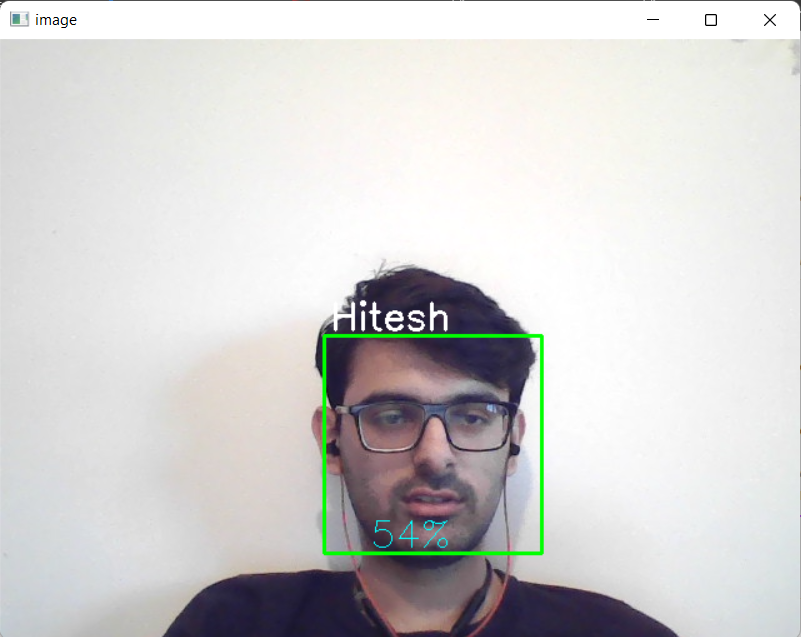